# Reinforcement Learning in Finite MDPs

In [0]:
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1

## MDPs

In [0]:
import sys
sys.path.insert(0, './mvarl_hands_on/utils')
import numpy as np
from scipy.special import softmax # for SARSA
import matplotlib.pyplot as plt
import json
import math
from cliffwalk import CliffWalk
from test_env import ToyEnv1

Setting up the environment

In [3]:
env = CliffWalk(proba_succ=0.98)

####################################################################################
# You probably want to test smaller enviroments before
#env = ToyEnv1(gamma=0.95)
####################################################################################

# Useful attributes
print("Set of states:", env.states)
print("Set of actions:", env.actions)
print("Number of states: ", env.Ns)
print("Number of actions: ", env.Na)
print("P has shape: ", env.P.shape)  # P[s, a, s'] = env.P[s, a, s']
print("discount factor: ", env.gamma)
print("")

# Usefult methods
state = env.reset() # get initial state
print("initial state: ", state)
print("reward at (s=1, a=3,s'=2): ", env.reward_func(1,3,2))
print("")

# A random policy
policy = np.random.randint(env.Na, size = (env.Ns,))
print("random policy = ", policy)

# Interacting with the environment
print("(s, a, s', r):")
for time in range(4):
    action = policy[state]
    next_state, reward, done, info = env.step(action)
    print(state, action, next_state, reward)
    if done:
        break
    state = next_state
print("")

Set of states: range(0, 48)
Set of actions: [0, 1, 2, 3]
Number of states:  48
Number of actions:  4
P has shape:  (48, 4, 48)
discount factor:  0.99

initial state:  36
reward at (s=1, a=3,s'=2):  0.6

random policy =  [2 2 0 0 0 2 2 1 2 0 0 0 3 0 0 3 3 0 3 3 2 1 2 0 0 3 2 3 0 1 2 3 0 3 3 1 0
 2 2 2 0 1 3 2 1 1 0 1]
(s, a, s', r):
36 0 37 0.6
37 2 36 0.0
36 0 37 0.6
37 2 36 0.0



# Nouvelle section

## Question 1: Value iteration
1. Write a function applying the optimal Bellman operator on a provided Q function: $Q_1 = LQ_0, \; Q_0\in \mathbb{R}^{S\times A}$
2. Write a function implementing Value Iteration (VI) with $\infty$-norm stopping condition (reuse function implemented in 1)
3. Evaluate the convergence of your estimate, i.e., plot the value $\|V_n - V^\star\|_{\infty}$

In [0]:
# --------------
# Point 1
# --------------
def bellman_operator(Q0, Ns, Na, R, P):
    Q1 = np.zeros((Ns,Na))
    for s in range(Ns) :
      for a in range(Na):
        Q1[s,a] = np.vdot(P[s,a,:],R[s,a,:]) + env.gamma*np.dot(P[s,a,:],np.max(Q0,axis=1))
    greedy_policy = np.argmax(Q1,axis=1)
    return Q1, greedy_policy

In [0]:
# --------------
# Point 2
# --------------
def value_iteration(Q0, env, epsilon=1e-5):
  rmax = np.max(np.abs(env.R))
  K = int(np.log(rmax/epsilon)/np.log(1/env.gamma))+1
  greedy_policy = np.argmax(Q0,axis=1)
  Q = Q0
  Q_history = [Q]
  for k in range(K):
    [Q, greedy_policy] = bellman_operator(Q,env.Ns,env.Na,env.R,env.P)
    Q_history.append(Q)
  return Q, greedy_policy, Q_history

Text(0.5, 1.0, 'Q-learning: Convergence of Q')

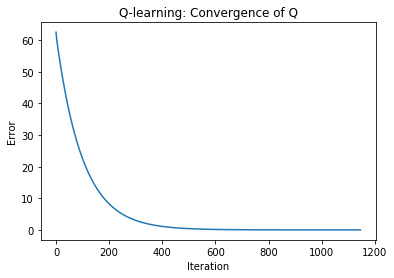

In [6]:
# --------------
# Point 3
# --------------
with open("./mvarl_hands_on/data/Q_opts.json", "r") as fp:
    Qopts = json.load(fp)
Qstar = Qopts["{}_{}".format(type(env).__name__,env.gamma)]
Q0 = np.random.rand(env.Ns,env.Na)
Q, greedy_policy, Q_history = value_iteration(Q0,env,epsilon=1e-5)
norm_values=[np.max(np.abs(Q-Qstar)) for Q in Q_history]



plt.plot(norm_values)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Q-learning: Convergence of Q")

In [7]:
state = env.reset()
env.render()
for i in range(50):
    action = greedy_policy[state]
    state, reward, done, _ = env.step(action)
    env.render()

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
|_: : : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| :_: : : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : :_: : : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : :_: : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : : :_: : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (right)
+---------------

## Question 2: Q learning
Q learning is a model-free algorithm for estimating the optimal Q-function online.
It is an off-policy algorithm since the samples are collected with a policy that is (potentially) not the one associated to the estimated Q-function.

1. Implement Q learning with $\epsilon$-greedy exploration.
  - Plot the error in Q-functions over iterations
  - Plot the cumulative sum of rewards

In [0]:
# ---------------------------
# Q-Learning
# ---------------------------

class QLearning:
    """
    Q learning with epsilon-greedy exploration
    """
    def __init__(self,Q):
      self.Q = Q

        
    
    def sample_action(self, state, greedy,env):
      action = greedy[state]
      next_state, reward, done, info = env.step(action)
      return next_state,reward,action
    
    def update(self, state, action, next_state, reward,alpha):
      delta = reward + env.gamma*np.max(self.Q[next_state,:]) - self.Q[state,action]
      self.Q[state,action] = Q[state,action] + alpha*delta
      return self.Q
    

+-----------------------+
| : : : : : : : : : : : |
| : : : : : : : : : : : |
| : : :_: : : : : : : : |
|S:x:x:x:x:x:x:x:x:x:x:G|
+-----------------------+
  (up)
None
optimal policy:  [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 3
 3 3 3 3 3 3 3 3 3 0 0]
est policy: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 3
 3 3 3 3 3 3 3 3 3 0 0]


Text(0.5, 1.0, 'Q-learning: Convergence of Q')

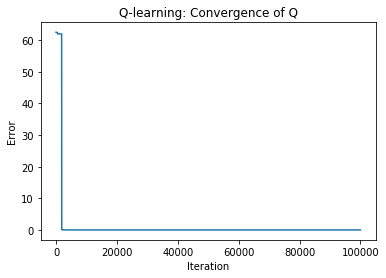

In [11]:
# --------------
# Point 1
# --------------
# Number of Q learning steps
max_steps = int(1e5)  



# Use the previous code to verify the correctness of q learning
Q0 = np.random.rand(env.Ns,env.Na)
Q_opt, pi_opt, _ = value_iteration(Q0, env, epsilon=1e-8)
q1 = QLearning(Q0)

# main algorithmic loop
norm_values = []
cumulative_sum_rewards = []
t = 0
epsilon = 0.1
state = env.states[0]
while t < max_steps:
    a = np.random.choice([0,1],p=[epsilon,1-epsilon])
    if a==0 :
      greedy = np.argmax(q1.Q,axis=1)
    if a==1:
      greedy = np.random.randint(env.Na, size = (env.Ns,))
    next_state,reward,action = q1.sample_action(state,greedy,env)  
    q1.Q = q1.update(state,action,next_state,reward,1/(t+1))
    norm_values.append(np.max(np.abs(q1.Q - Q_opt))) 
    cumulative_sum_rewards.append(reward)
    state = next_state
    t = t + 1
print(env.render())
print("optimal policy: ", pi_opt)
greedy_policy = np.argmax(q1.Q, axis=1)
print("est policy:", greedy_policy)


plt.plot(norm_values)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title("Q-learning: Convergence of Q")





Text(0.5, 1.0, 'cumulative sum of rewards')

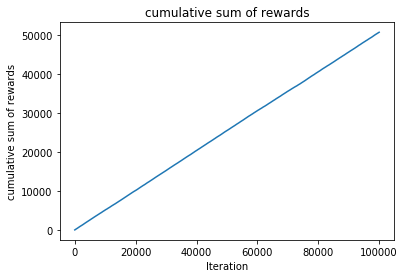

In [12]:
cumulative_sum_rewards = np.array(cumulative_sum_rewards)
cumulative_sum_rewards = np.cumsum(cumulative_sum_rewards)
plt.plot(cumulative_sum_rewards)
plt.xlabel('Iteration')
plt.ylabel('cumulative sum of rewards')
plt.title("cumulative sum of rewards")